In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rng = np.random.default_rng()

In [2]:
def replace_with_sample(x,distr):
    "x will be a value in a column of the data frame, and distr will be the probability distr of the column w/o '?' "
    if x == "?":
        return distr.sample(weights=distr.values).index[0]
    return x
#designed this because rng.choice and pd.replace wasn't working as intended

def clean_data(train_data, test_data):
    '''
    Function to clean the missing values. See instructions on PDF file or below in MD cell
    '''
    #dropping columns
    train_data.drop(columns = ["fnlwgt", "education.num"], inplace = True)
    test_data.drop(columns = ["fnlwgt", "education.num"], inplace = True)

    #filling in missing values (never worked with no occupation)
    train_data.occupation =  np.where(train_data.workclass == "Never-worked", "No Occupation", train_data.occupation)
    test_data.occupation =  np.where(test_data.workclass == "Never-worked", "No Occupation", test_data.occupation)

    #relabel the income column
    train_data.income = np.where(train_data.income == ">50K", 1, 0)
    test_data.income = np.where(test_data.income == ">50K", 1, 0)
    
    #simplfying race
    train_data.race = np.where(train_data.race == "White", "White", "Other")
    test_data.race = np.where(test_data.race == "White", "White", "Other")

    #simplfying education
    train_data.education = train_data.education.str.replace(r'[\d].*', "School", regex = True).str.replace('Preschool', "School")
    test_data.education = test_data.education.str.replace(r'[\d].*', "School", regex = True).str.replace('Preschool', "School")

    #Handling Capital gain 99999. When calling train_data.describe() it looks like about 90% of data had 0 as a capital gain and as a capital loss
    train_data["capital.loss"]= train_data["capital.loss"].replace(99999,0)
    train_data["capital.gain"]= train_data["capital.gain"].replace(99999,0)
    test_data["capital.loss"]= test_data["capital.loss"].replace(99999,0)  #replacing with 0 because 90% of data in train_set had 0 as a capital gain and as a capital loss
    test_data["capital.gain"]= test_data["capital.gain"].replace(99999,0)

    #Replacing question marks in occupation using a probility distriubtion of occupation counts
    prob_distr_train = train_data.occupation.value_counts()/np.sum(train_data.occupation.value_counts())
    without_q_occupation = prob_distr_train[prob_distr_train.index != "?"]/np.sum(prob_distr_train[prob_distr_train.index != "?"])
    train_data.occupation = train_data.occupation.apply(lambda x: replace_with_sample(x, without_q_occupation))

    prob_distr_test = test_data.occupation.value_counts()/np.sum(test_data.occupation.value_counts())
    without_q_occupation = prob_distr_test[prob_distr_test.index != "?"]/np.sum(prob_distr_test[prob_distr_test.index != "?"])
    test_data.occupation = test_data.occupation.apply(lambda x: replace_with_sample(x, without_q_occupation))

    #replacing question marks in work class using a probability distribution of workclass counts
    prob_distr_train = train_data.workclass.value_counts()/np.sum(train_data.workclass.value_counts())
    without_q_workclass = prob_distr_train[prob_distr_train.index != "?"]/np.sum(prob_distr_train[prob_distr_train.index != "?"])
    train_data.workclass = train_data.workclass.apply(lambda x: replace_with_sample(x, without_q_workclass))

    prob_distr_test = test_data.workclass.value_counts()/np.sum(test_data.workclass.value_counts())
    without_q_workclass = prob_distr_test[prob_distr_test.index != "?"]/np.sum(prob_distr_test[prob_distr_test.index != "?"])
    test_data.workclass = test_data.workclass.apply(lambda x: replace_with_sample(x, without_q_workclass))

    #Replacing the question marks in the native countries column with United-States (mode of column)
    train_data["native.country"] = train_data["native.country"].replace("?", "United-States")
    test_data["native.country"] = test_data["native.country"].replace("?", "United-States")
    
    train_data.to_csv('cleaned_train_data.csv', index=False)
    test_data.to_csv('cleaned_test_data.csv', index=False)
    return

In [3]:
def plot_numeric_feature_correlation(train_data):
    numeric = train_data[["age", "capital.gain", "capital.loss", "hours.per.week", "income"]]
    heated = numeric.corr()
    #plt.figure(figsize = (8,8))
    sns.heatmap(data = heated, annot = True, cmap = "rocket")
    plt.title("Correlation Between Different Features")
    return

In [4]:
def plot_histogram(train_data):
    together = ["workclass", "education", "marital.status", "relationship", "race", "sex", "capital.gain", "capital.loss", "occupation"]
    plt.figure(figsize = (13,15))
    for i in range(len(together)):
        plt.subplot(4,3,i+1)
        sns.histplot(data = train_data, x= together[i], hue = "income", multiple = "dodge", shrink = .8)
        plt.title(f"Histogram of Income Class vs {together[i]}")
        plt.ylabel("Frequency")
        plt.xlabel("")
        plt.xticks(rotation=60)
        plt.legend(loc = "upper right", labels = [">50k","<50k"])
    plt.tight_layout()

    #smaller bars need to have label >50k
    
    #Splitting because these three need different bin widths for plotting
    not_tog = ["age","hours.per.week", "native.country"]
    plt.figure(figsize= (13,5))
    for i in range(len(not_tog)):
        plt.subplot(1,3,i+1)
        sns.histplot(data= train_data, hue = 'income', x = not_tog[i], multiple = "dodge", binwidth = 10, shrink = .8)
        plt.title(f"Histogram of Income Class vs {not_tog[i]}")
        plt.ylabel("Frequency")
        plt.xlabel("")
        plt.xticks(rotation=60)
        plt.legend(loc = "upper right", labels = [">50k","<50k"])
    plt.tight_layout()
    #had to adjust binwidths for this one
    #plt.subplot(2,3,6)    
    return

### Cleaning Data Instructions

In [5]:
# Load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
train_data.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,48,Private,191858,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
1,54,Private,145419,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,1672,50,United-States,<=50K
2,43,Private,182757,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K


In [6]:
clean_data(train_data, test_data)

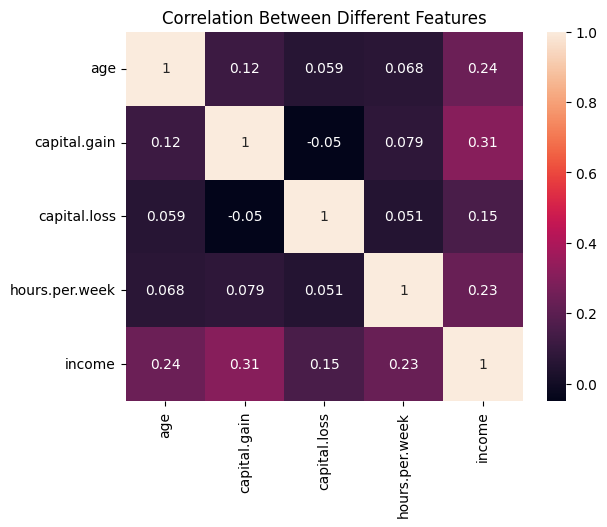

In [7]:
plot_numeric_feature_correlation(train_data)

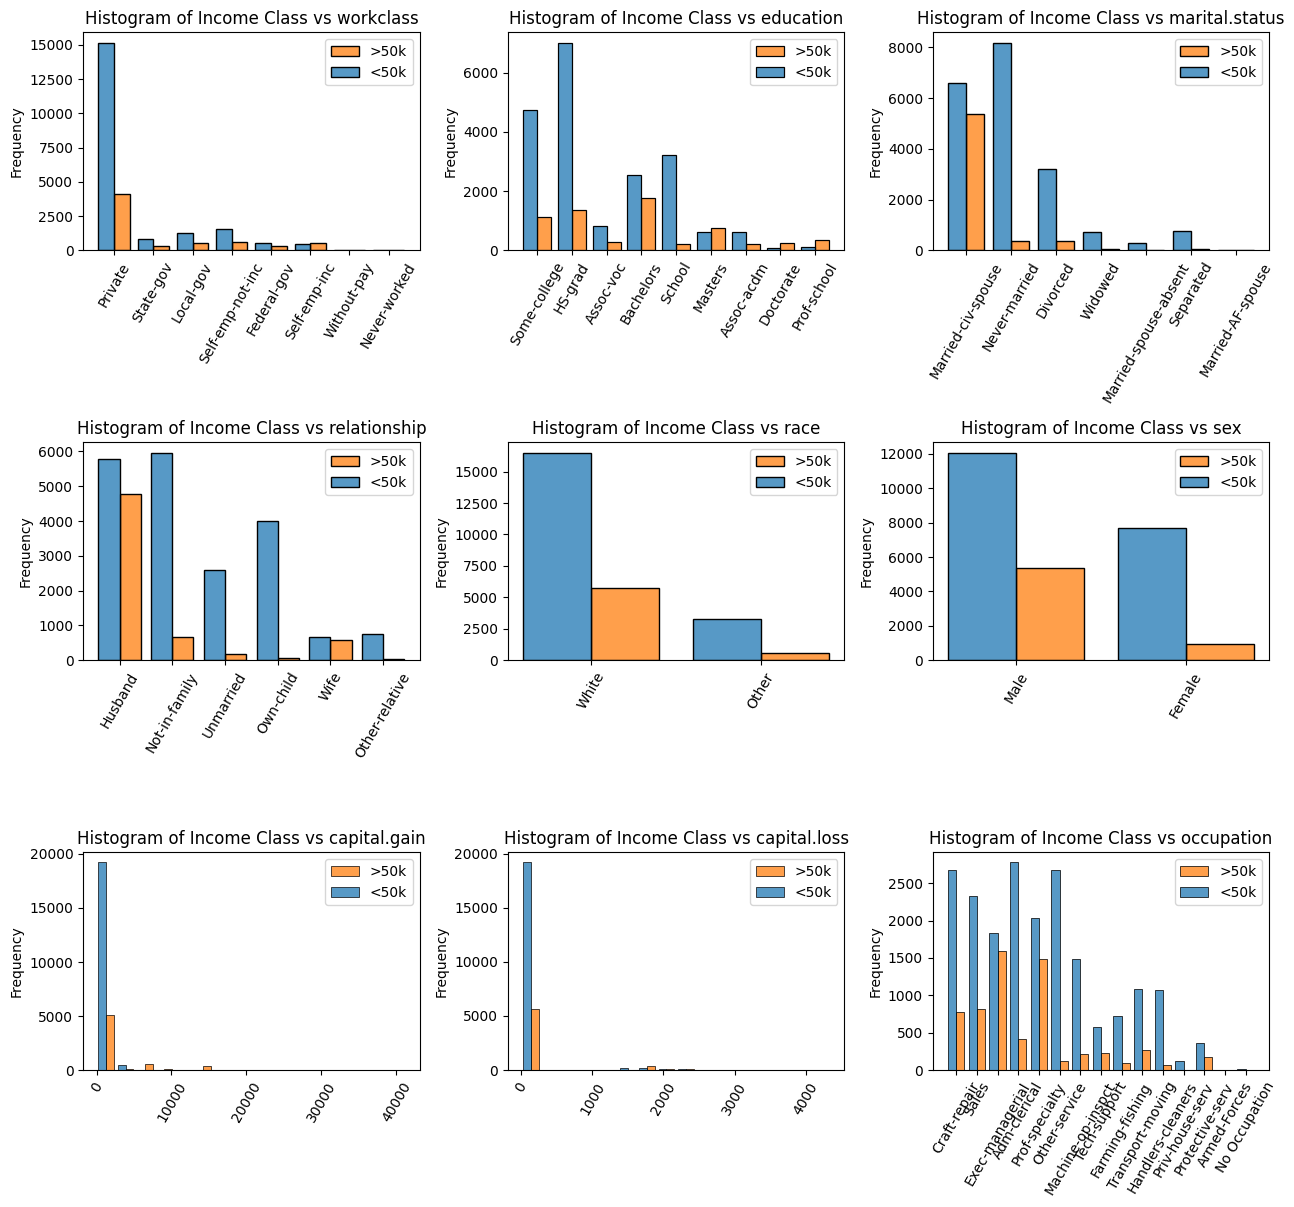

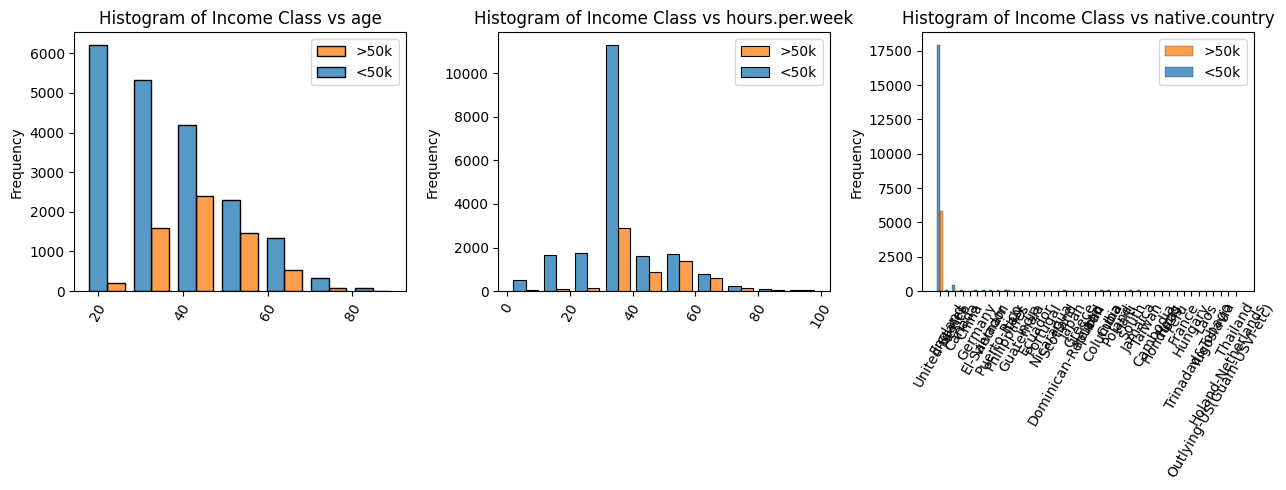

In [8]:
plot_histogram(train_data)